In [49]:
%reset

In [50]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [51]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNLE, SNPE#, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
from joblib import Parallel, delayed, parallel_backend
from scipy.integrate import quad, simpson
import pickle
from scipy.stats import norm
import sources.DMsignal as DMsignal
import sources.FermiBackgrounds as FermiBackgrounds


%matplotlib inline

In [52]:
grains=1000
num_simulations = 1000
num_workers = 48

In [53]:
parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1000, 100000] #MeV 
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
# max_radius = 8.5 + 20*2 #kpc
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = np.pi #angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [54]:
my_cosmology = 'Planck18'
# z_range = [0, 14]
# luminosity_range = 10.0**np.array([33, 50]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.

lower_bound_luminosity = 1e35 # photons/s
upper_bounds_luminosity = np.array([1e35, 1e40, 1e45, 1e50, 1e55, 1e60]) # photons/s
luminosity_range_initialize = np.array([lower_bound_luminosity, upper_bounds_luminosity[0]]) # photons/s # This is only to initialize the AEGIS object, it will be updated later

# AEGIS object for Dark matter signal
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range_aegis, energy_range, luminosity_range_initialize, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen = angular_cut_gen, lat_cut_gen


In [55]:
# 1) Point to your data directory and choose a channel
data_dir = "/home/users/ids29/DGRB/data/dm_spectra/"         # must contain AtProduction_gammas.dat
channel  = "Tau"                           # e.g. 'b' (bottom quarks) or 'Tau'


# 2) Build the DMsignal object
dm = DMsignal.DMsignal(directory=data_dir, channel=channel)

Dark Matter Model

In [56]:
def DM_abundance(r, L, params): # Outputs the abundance function in the form dN/dV/dL. Note the dV.
    """
    Abundance function for the DM signal.
    """
    # r is the distance from the source # kpc
    # L is the luminosity of the source # photons/second
    # return the abundance function in the form dN/dV/dL in units of 1 / (kpc^3 photon/second)
    # params conatins 'mass of DM particle in GeV'


    A_DM = params[0]
    mass_DM_GeV = params[1] # UPDATE TO THE CURRENT PARAMS INDEX

    
    beta = 1.9
    A = 1.2e4 # MSolar^{-1} kpc^{-3}
    r_s = 21 #kpc
    r_tilde = r / r_s # unitless
    cross_section = 3e-26 #cm^3 s^{−1}
    
    def compute_integral_E(E_min: float, E_max: float, n_points: int = 10_001) -> float:
        """
        Compute ∫ dN/dE dE between E_min and E_max [MeV]
        by sampling on a uniform grid and applying Simpson's rule.
        n_points must be odd for Simpson's rule.
        """
        # make sure we have an odd number of points
        if n_points % 2 == 0:
            n_points += 1

        E = np.linspace(E_min, E_max, n_points)
        dNdE = dm.get_dNdE(
            desired_E_MeV=E,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )
        return simpson(dNdE, E)

    Emin, Emax = energy_range[0], energy_range[1]
    integral_E = compute_integral_E(Emin, Emax)



    Phi_pp = A_DM * cross_section / (8 * np.pi * mass_DM_GeV**2) * integral_E  # cm^3 s^{-1} GeV^{-2}

    
    def integrand_M_tilde(M_tilde):
        sigma = 0.74 + 0.011 * np.log(r/50) - 0.003 * M_tilde / 0.87
        Delta = np.log(L) - 77.4 + 0.23*np.log(r/50) - np.log((8*np.pi*Phi_pp)/(1e-28)) # unitless
        mu = sigma**2 * (1-beta) / 0.87  +  Delta
        return np.exp((mu**2 -Delta**2)/(2*sigma**2)) * np.exp(-(M_tilde - mu)**2/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)
    


    def compute_integral_M_tilde_simpson(M_tilde_min: float, M_tilde_max: float, n_points: int = 10001) -> float:
        """
        Integrate integrand_M_tilde from M_min to M_max using Simpson's rule.
        n_points must be odd; if it's even, it's incremented by 1.
        """
        if n_points % 2 == 0:
            n_points += 1
        M_tilde = np.linspace(M_tilde_min, M_tilde_max, n_points)
        M_tilde_vec = M_tilde[:, None, None]  # add broadcast dims  # (10001, 1, 1)
        y = integrand_M_tilde(M_tilde_vec)
        # print(f"y.shape: {y.shape}")
        return simpson(y, M_tilde, axis=0)


    # Example usage:
    M_min = 1 # MSolar
    M_tilde_min = 0.87 * np.log(M_min/1e5) # M_min = 1 MSolar
    integral_M_tilde = compute_integral_M_tilde_simpson(M_tilde_min, 14.0) # The integrand 'integrand_M_tilde' is sufficiently suppressed for all M_tilde > 14.0



    
    return 10**(5*(1-beta)) * A / (0.87 * L * r_tilde * (1+r_tilde)**2)   * integral_M_tilde # units of 1 / (kpc^3 photon/second)


def DM_abundance_dR(x, L, params): # Returns the abundance function in the form dN/dR/dL. Note the dR. # this function needs to be passed to AEGIS
    r = np.sqrt(x**2 + 8.5**2 - 2 * 8.5 * x * np.cos(np.deg2rad(40))) # x is the ad-hoc distance from the center of the Milky Way in kpc, and 8.5 is the distance of the Sun from the center of the Milky Way in kpc
    return 4*np.pi*r**2 * DM_abundance(r, L, params) # dV = 4*np.pi*r^2 dr, so we need to multiply by 4*np.pi*r^2


def DM_spectrum(energy, params): #'energy' is an array of energies in MeV 
    return dm.get_dNdE(
            desired_E_MeV=energy,
            channel=channel,
            mass_MeV= mass_DM_GeV * 1e3
        )

In [57]:
# Case 1: [lower_limit_ADM, lower_limit_Mchi]
# Case 2: [lower_limit_ADM, upper_limit_Mchi]
# Case 3: [upper_limit_ADM, lower_limit_Mchi]
# Case 4: [upper_limit_ADM, upper_limit_Mchi]
params_cases = [np.array([100, 150]), np.array([100, 350]), np.array([500, 150]), np.array([500, 350])]
case = 4 # Chose the case you want to use, 1, 2, 3 or 4

num_samples = 100
x_limits = np.array([0, max_radius]) # kpc
lums = np.geomspace(lower_bound_luminosity, upper_bounds_luminosity[-1], num_samples) # photons/s

abundances = np.zeros((len(x_limits), len(lums))) # abundance function in the form dN/dR/dL

for i, x in enumerate(x_limits):
    for j, lum in enumerate(lums):
        abundances[i, j] = DM_abundance_dR(x, lum, params_cases[case-1]) # abundance function in the form dN/dR/dL

/tmp/ipykernel_1809478/1829848482.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  abundances[i, j] = DM_abundance_dR(x, lum, params_cases[case-1]) # abundance function in the form dN/dR/dL


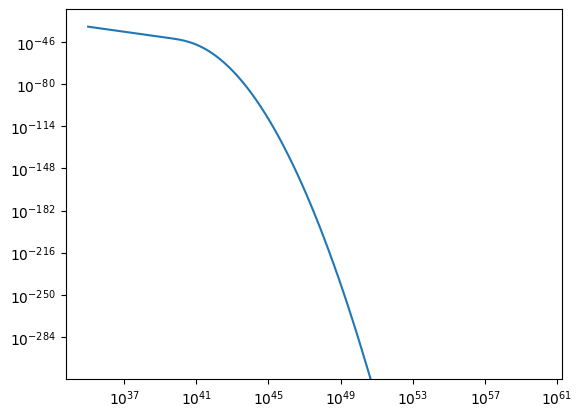

In [59]:
plt.loglog(lums, abundances[1,:])
plt.show()